<a href="https://colab.research.google.com/github/med-tz/yoga/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Adam
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
from scipy import stats
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
XchTrain = np.load("/gdrive/MyDrive/sabri/trainX.npy")
YTrain = np.load("/gdrive/MyDrive/sabri/trainY.npy")
XchVal = np.load("/gdrive/MyDrive/sabri/valX.npy")
YVal = np.load("/gdrive/MyDrive/sabri/valY.npy")
XchTest = np.load("/gdrive/MyDrive/sabri/testX.npy")
YTest = np.load("/gdrive/MyDrive/sabri/testY.npy")
# making test and train labels one hot
YintTrain = np.int64(YTrain)
YhotTrain = np.zeros((YTrain.shape[0], 6))
YhotTrain[np.arange(YTrain.shape[0]), YintTrain] = 1

YintTest = np.int64(YTest)
YhotTest = np.zeros((YTest.shape[0], 6))
YhotTest[np.arange(YTest.shape[0]), YintTest] = 1

YintVal = np.int64(YVal)
YhotVal = np.zeros((YVal.shape[0], 6))
YhotVal[np.arange(YVal.shape[0]), YintVal] = 1

YhotTest = np.repeat(YhotTest[:, :, np.newaxis], 45, axis=2)
YhotTest = np.swapaxes(YhotTest, 1, 2)

YhotVal = np.repeat(YhotVal[:, :, np.newaxis], 45, axis=2)
YhotVal = np.swapaxes(YhotVal, 1, 2)

YhotTrain = np.repeat(YhotTrain[:, :, np.newaxis], 45, axis=2)
YhotTrain = np.swapaxes(YhotTrain, 1, 2)

In [3]:
print(XchTrain.shape)
print(YhotTrain.shape)
print(XchVal.shape)
print(YhotVal.shape)
print(XchTest.shape)
print(YhotTest.shape)

(7754, 45, 25, 2)
(7754, 45, 6)
(2529, 45, 25, 2)
(2529, 45, 6)
(2519, 45, 25, 2)
(2519, 45, 6)


In [4]:
def get_model():
    model = Sequential([
        TimeDistributed(Conv1D(16,3, activation='relu', padding = "same"),input_shape=XchTrain.shape[1:]),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(Dropout(0.5)),
        BatchNormalization(),
        TimeDistributed(Flatten()),  
        LSTM(20,unit_forget_bias = 0.5, return_sequences = True),
        TimeDistributed(Dense(6,activation='softmax'))        
    ])
    adam = Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])
    return model

In [5]:
model = get_model()
filepath= "/gdrive/MyDrive/sabri/" +"val1" + "-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model_history = model.fit(XchTrain, YhotTrain, epochs=100, batch_size=32, validation_data = (XchVal, YhotVal))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
243/243 [==============================] - 37s 49ms/step - loss: 1.4605 - accuracy: 0.4562 - val_loss: 0.5869 - val_accuracy: 0.9037
Epoch 2/100
243/243 [==============================] - 11s 44ms/step - loss: 0.4945 - accuracy: 0.9356 - val_loss: 0.2616 - val_accuracy: 0.9726
Epoch 3/100
243/243 [==============================] - 11s 44ms/step - loss: 0.2343 - accuracy: 0.9712 - val_loss: 0.1843 - val_accuracy: 0.9763
Epoch 4/100
243/243 [==============================] - 11s 43ms/step - loss: 0.1622 - accuracy: 0.9770 - val_loss: 0.1373 - val_accuracy: 0.9791
Epoch 5/100
243/243 [==============================] - 11s 45ms/step - loss: 0.1292 - accuracy: 0.9810 - val_loss: 0.1216 - val_accuracy: 0.9799
Epoch 6/100
243/243 [==============================] - 11s 44ms/step - loss: 0.1049 - accuracy: 0.9838 - val_loss: 0.1048 - val_accuracy: 0.9810
Epoch 7/100
243/243 [==============================] - 11s 44ms/step - loss: 0.0915 - accuracy: 0.9851 - val_loss: 0.0966 - val_ac

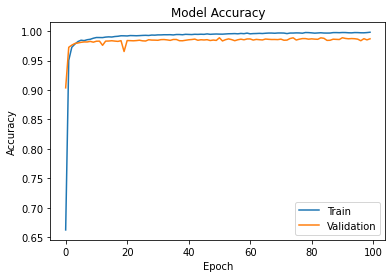

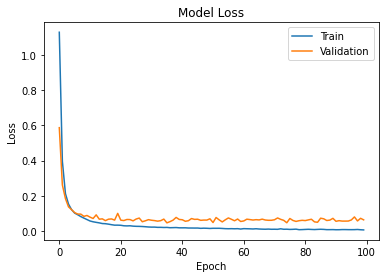

In [6]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
#plt.savefig('accHigh.svg')

# # Plot loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('lossHigh.svg')

In [7]:
preds = model.predict(XchTest)

In [8]:
print(preds.shape)

(2519, 45, 6)


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm = cm
        #print("Normalized confusion matrix")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
Yhot_pred = model.predict(XchTest)
#convert them to class numbers

In [11]:
Y_pred = np.argmax(preds, axis = 2)
Y_test = np.argmax(YhotTest, axis = 2)
print(Y_pred.shape)
print(Y_test.shape)

(2519, 45)
(2519, 45)


In [12]:
ans = 0
for i in range(Y_test.shape[0]):    
        for j in range(Y_test.shape[1]):
            if Y_test[i][j] == Y_pred[i][j]:
                ans = ans + 1    
print("Test Accuracy Framewise is")
#print ans
print((ans/float(Y_test.shape[0] * Y_test.shape[1]))*100)

Test Accuracy Framewise is
98.28238719068413


In [13]:

# use polling of 45 frames to get output for the sequence
ans = 0
res = []
act = []
for i in range(Y_test.shape[0]):
    resTemp = stats.mode(Y_pred[i])
    actTemp = stats.mode(Y_test[i])
    res.append(resTemp[0][0])
    act.append(actTemp[0][0])
    if res[i] == act[i]:
        ans = ans + 1
    """for j in range(Y_test.shape[1]):
        if Y_test[i][j] != Y_pred[i][j]:
            print Y_pred[i]
            break"""
                
print("Test Accuracy with Polling is")
#print ans
print(ans/float(Y_test.shape[0])*100)

Test Accuracy with Polling is
98.76935291782453


In [14]:
Y_pred_flat = []
Y_test_flat = []
for i in range(Y_test.shape[0]):    
        for j in range(Y_test.shape[1]):
            Y_pred_flat.append(Y_pred[i][j])
            Y_test_flat.append(Y_test[i][j])

In [15]:
asanas = {0:'bhujangasan', 1:'padamasan', 2:'shavasan', 3:'tadasan', 4:'trikonasan', 5:'vrikshasan'}
#uncomment for framewise
Y_asanas = np.array([asanas[a] for a in Y_test_flat])
Y_pred_asanas = np.array([asanas[a] for a in Y_pred_flat])
#Y_asanas = np.array([asanas[a] for a in act])
#Y_pred_asanas = np.array([asanas[a] for a in res])
print(Y_asanas)
print(Y_pred_asanas)

['bhujangasan' 'bhujangasan' 'bhujangasan' ... 'vrikshasan' 'vrikshasan'
 'vrikshasan']
['bhujangasan' 'bhujangasan' 'bhujangasan' ... 'vrikshasan' 'vrikshasan'
 'vrikshasan']


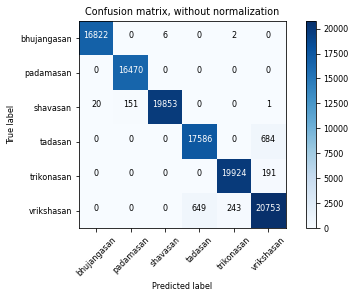

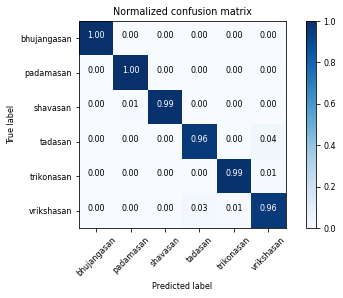

In [16]:
plt.rcParams.update({'font.size': 8})
class_names =[]
for k in range(6):
    class_names.append(asanas[k])
cnf_matrix = confusion_matrix(Y_asanas, Y_pred_asanas)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.savefig('confHighFrame.svg')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('nconfHighFrame.svg')